# Data Preparation

## Initialize Modules and Configurations

In [4]:
# Import required modules
import pandas as pd
import numpy as np
import pickle

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Import Data

In [5]:
# Import training data set
train = pd.read_csv("../data/raw/train.csv.zip", compression="zip", index_col='id')

# Import metadata create from exploratory stage
meta_data = pd.read_csv("../references/training_metadata.csv")

# Import variables to drop determined in exploratory
cont_names_to_drop = pickle.load(open("../data/interim/cont_names_to_drop.p", "rb" ))

# Tasks
tasks = pickle.load(open( "../data/interim/data_prep_tasks.p", "rb" ))
print(tasks)

{'Take natural log of target': "np.log(train['loss'])", 'Create category to split cont13 into two': "train['cont13'] < .5"}


## Establish Variables from Metadata

In [6]:
# Seperate Continious and Categorical Attributes
cat_names = meta_data[meta_data['Data Type']=='object']['Variable']
cont_names = meta_data[(meta_data['Data Type']=='float64') & 
                       (meta_data['Variable']!='loss')]['Variable']

cont_names_final = cont_names[~cont_names.isin(cont_names_to_drop)]

## Transform target 'loss' by natural log

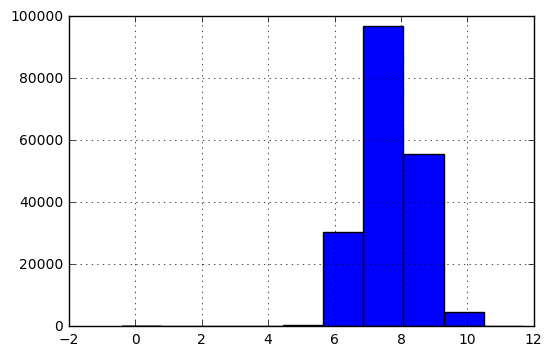

In [11]:
%matplotlib inline
target = np.log(train['loss'])
target.hist()

# Binary Encoded Feature Dataset

In [12]:
import category_encoders as ce
encoder = ce.BinaryEncoder()

categorical_data = encoder.fit_transform(train[cat_names])
continuous_data = train[cont_names]

train_binary = pd.concat([target, continuous_data, categorical_data], axis=1)
#train_binary.to_csv("../data/processed/train_binary_encoded.csv", index=False)
train_binary.to_pickle("../data/processed/train_binary_encoded.p")

C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\category_encoders\ordinal.py:190: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  X[col] = X[col].astype(int).reshape(-1, )
C:\Users\ryan.shuhart\AppData\Local\Continuum\Anaconda3\lib\site-packages\category_encoders\ordinal.py:179: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  X[switch.get('col')] = X[switch.get('col')].astype(int).reshape(-1, )


In [13]:
train_binary.head()

,loss,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,cat1_0,cat2_0,cat3_0,cat4_0,cat5_0,cat6_0,cat7_0,cat8_0,cat9_0,cat10_0,cat11_0,cat12_0,cat13_0,cat14_0,cat15_0,cat16_0,cat17_0,cat18_0,cat19_0,cat20_0,cat21_0,cat22_0,cat23_0,cat24_0,cat25_0,cat26_0,cat27_0,cat28_0,cat29_0,cat30_0,cat31_0,cat32_0,cat33_0,cat34_0,cat35_0,cat36_0,cat37_0,cat38_0,cat39_0,cat40_0,cat41_0,cat42_0,cat43_0,cat44_0,cat45_0,cat46_0,cat47_0,cat48_0,cat49_0,cat50_0,cat51_0,cat52_0,cat53_0,cat54_0,cat55_0,cat56_0,cat57_0,cat58_0,cat59_0,cat60_0,cat61_0,cat62_0,cat63_0,cat64_0,cat65_0,cat66_0,cat67_0,cat68_0,cat69_0,cat70_0,cat71_0,cat72_0,cat73_0,cat73_1,cat74_0,cat74_1,cat75_0,cat75_1,cat76_0,cat76_1,cat77_0,cat77_1,cat78_0,cat78_1,cat79_0,cat79_1,cat80_0,cat80_1,cat81_0,cat81_1,cat82_0,cat82_1,cat83_0,cat83_1,cat84_0,cat84_1,cat85_0,cat85_1,cat86_0,cat86_1,cat87_0,cat87_1,cat88_0,cat88_1,cat89_0,cat89_1,cat89_2,cat90_0,cat90_1,cat90_2,cat91_0,cat91_1,cat91_2,cat92_0,cat92_1,cat92_2,cat93_0,cat93_1,cat93_2,cat94_0,cat94_1,cat94_2,cat95_0,cat95_1,cat95_2,cat96_0,cat96_1,cat96_2,cat97_0,cat97_1,cat97_2,cat98_0,cat98_1,cat98_2,cat99_0,cat99_1,cat99_2,cat99_3,cat100_0,cat100_1,cat100_2,cat100_3,cat101_0,cat101_1,cat101_2,cat101_3,cat101_4,cat102_0,cat102_1,cat102_2,cat102_3,cat103_0,cat103_1,cat103_2,cat103_3,cat104_0,cat104_1,cat104_2,cat104_3,cat104_4,cat105_0,cat105_1,cat105_2,cat105_3,cat105_4,cat106_0,cat106_1,cat106_2,cat106_3,cat106_4,cat107_0,cat107_1,cat107_2,cat107_3,cat107_4,cat108_0,cat108_1,cat108_2,cat108_3,cat109_0,cat109_1,cat109_2,cat109_3,cat109_4,cat109_5,cat109_6,cat110_0,cat110_1,cat110_2,cat110_3,cat110_4,cat110_5,cat110_6,cat110_7,cat111_0,cat111_1,cat111_2,cat111_3,cat112_0,cat112_1,cat112_2,cat112_3,cat112_4,cat112_5,cat113_0,cat113_1,cat113_2,cat113_3,cat113_4,cat113_5,cat114_0,cat114_1,cat114_2,cat114_3,cat114_4,cat115_0,cat115_1,cat115_2,cat115_3,cat115_4,cat116_0,cat116_1,cat116_2,cat116_3,cat116_4,cat116_5,cat116_6,cat116_7,cat116_8
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7.702186,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1,1,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,0,0,0,1,1,1,1,0,0,1
2,7.157424,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,0
5,8.008063,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,1,0,0,1,1,0,0,0,1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,